## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import random
import re
from matplotlib import pyplot as plt
from torch.nn import functional as F
import torch.nn as nn
import torch
from torch.autograd import Variable

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [9]:
text = ("".join(text)).lower()
text_len = len(text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [10]:
tokens = sorted(set([i for i in text if i.isalpha()]))
tokens.extend(["<", " ", ".", "!", "?", ","])

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [11]:
token_to_idx = {}
idx_to_token = []
ch = 0
for i in tokens:
    token_to_idx[i] = ch
    idx_to_token.append(i)
    ch+=1

In [12]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, text_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk())

compeers by night
  giving him aid, my verse astonished.
  he, nor that affable familiar ghost
  which nightly gulls him with intelligence,
  as victors of my silence cannot boast;
  i was not sick of 


*Comment: in this task we have only 58 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input[0], hidden)
        output = self.decoder(output)
        return output, hidden

    def initial_state(self):
        return torch.zeros(1, self.hidden_size, requires_grad=True)

In [14]:
def char_tensor(x):
    res = [token_to_idx[i] for i in x]
    return torch.Tensor(res).to(torch.int64)

In [15]:
str_leg = ''.join(idx_to_token)
def get_training_set():  
    chunk = random_chunk()
    chunk = re.sub('[^' + str_leg + ']', '', chunk)
    chunk = ' '.join(chunk.split())
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [17]:
def train_vanila(model, criterion, optimizer ,inp, target):
    hidden = model.initial_state()
    model.zero_grad()
    loss = 0
    for c in range(len(inp)):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output[0], target[c])
    loss.backward()
    optimizer.step()
    return loss.item() / len(inp)

In [18]:
def train_loop(model, vanila = True):
    n_epochs = 2000
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = nn.CrossEntropyLoss()

    all_losses = []
    loss_avg = 0

    for epoch in range(1, n_epochs + 1):
        if vanila:
            loss = train_vanila(model, criterion, optimizer, *get_training_set()) 
        else:
            loss = train_LSTM(model, criterion, optimizer, *get_training_set())       
        loss_avg += loss
        all_losses.append(loss)
        print("Epoch", epoch, "; Loss = ", loss)
    return all_losses

In [19]:
model = RNN(len(tokens), 100, len(tokens))
losses = train_loop(model)

Epoch 1 ; Loss =  3.434536626430157
Epoch 2 ; Loss =  3.236150214012633
Epoch 3 ; Loss =  3.0659301101520495
Epoch 4 ; Loss =  3.0135960732736895
Epoch 5 ; Loss =  2.855347013212944
Epoch 6 ; Loss =  2.7560992951088763
Epoch 7 ; Loss =  2.905164821173555
Epoch 8 ; Loss =  2.4918019128224205
Epoch 9 ; Loss =  2.6624684435255985
Epoch 10 ; Loss =  2.6289710998535156
Epoch 11 ; Loss =  2.33793583018257
Epoch 12 ; Loss =  2.4731773093894676
Epoch 13 ; Loss =  2.466897403492647
Epoch 14 ; Loss =  2.3628142485747468
Epoch 15 ; Loss =  2.498644793475116
Epoch 16 ; Loss =  2.4312524209475384
Epoch 17 ; Loss =  2.570290610428256
Epoch 18 ; Loss =  2.457003734150871
Epoch 19 ; Loss =  2.4114191958778783
Epoch 20 ; Loss =  2.5468607907572753
Epoch 21 ; Loss =  2.3183158017734793
Epoch 22 ; Loss =  2.3833643863075658
Epoch 23 ; Loss =  2.313480296033494
Epoch 24 ; Loss =  2.3464974023962535
Epoch 25 ; Loss =  2.3053450888775764
Epoch 26 ; Loss =  2.231704549586519
Epoch 27 ; Loss =  2.296255558095

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [20]:
def get_plot(losses):
    plt.figure(figsize=(11, 5))
    plt.title("Loss")
    plt.plot(range(len(losses)), losses, linewidth=2)
    plt.show()

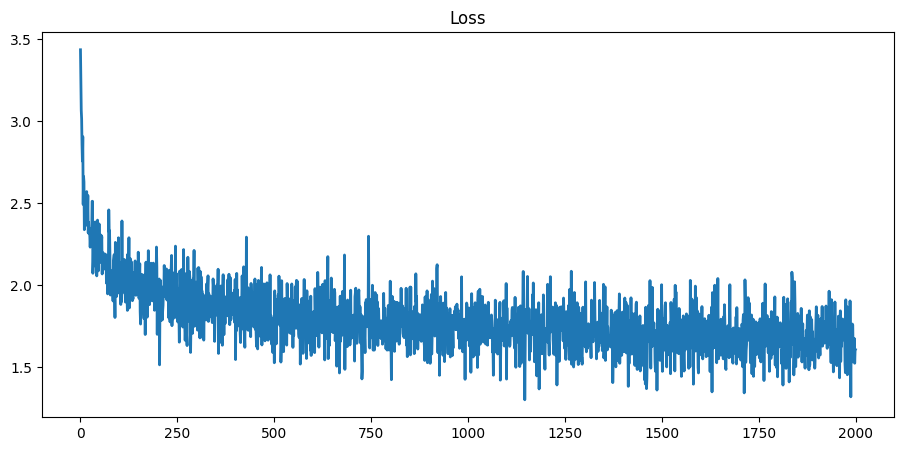

In [21]:
get_plot(losses)

In [38]:
def generate_sample(char_rnn, seed_phrase='<', max_length=100, temperature=1.0, vanila = True):
    seed_phrase = seed_phrase.lower()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    hid_state = char_rnn.initial_state()
    cn = char_rnn.initial_state()
    for i in range(len(seed_phrase) - 1):
        if vanila:
            out, hid_state = char_rnn(x_sequence[i], hid_state)
        else:
            out, hid_state, cn = char_rnn(x_sequence[i], hid_state, cn)
    
    for _ in range(max_length - len(seed_phrase) + 1):
        if vanila:
            out, hid_state = char_rnn(x_sequence[-1], hid_state)
        else:
            out, hid_state, cn = char_rnn(x_sequence[-1], hid_state, cn)

        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        next_ix = np.random.choice(len(idx_to_token), p=p_next)
        next_ix = torch.tensor([next_ix], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix])
    return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy() if ix != 26])

In [26]:
# An example of generated text.
print(generate_sample(model, seed_phrase='<Hello', max_length = 200, temperature=1))

hellow if migh sovden true not milengall one the pared the consarm then, and thine ntiquls, and rich thy with is bysed, and that but thy he mine of mays frowarden. o! celigence, bus my were thee, sexc


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [27]:
def train_LSTM(model, criterion, optimizer ,inp, target):
    hidden = model.initial_state()
    cn = model.initial_state()
    model.zero_grad()
    loss = 0
    for c in range(len(inp)):
        output, hidden, cn = model(inp[c], hidden, cn)
        loss += criterion(output[0], target[c])
    loss.backward()
    optimizer.step()
    return loss.item() / len(inp)

In [28]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden, cn):
        input = self.encoder(input.view(1, -1))
        output, (hidden, cn) = self.lstm(input[0], (hidden, cn))
        output = self.decoder(output)
        return output, hidden, cn

    def initial_state(self):
        return torch.zeros(1, self.hidden_size, requires_grad=True)

In [31]:
model = LSTM(len(tokens), 100, len(tokens))
losses = train_loop(model ,False)

Epoch 1 ; Loss =  3.4512980143229166
Epoch 2 ; Loss =  3.3712395562065973
Epoch 3 ; Loss =  3.254854742855949
Epoch 4 ; Loss =  3.1668444357283128
Epoch 5 ; Loss =  3.012073981068122
Epoch 6 ; Loss =  2.9375321583081315
Epoch 7 ; Loss =  2.812597590971758
Epoch 8 ; Loss =  2.7856869346217104
Epoch 9 ; Loss =  2.55178421534849
Epoch 10 ; Loss =  2.7833821614583334
Epoch 11 ; Loss =  2.5751747532894735
Epoch 12 ; Loss =  2.717830901450299
Epoch 13 ; Loss =  2.5629120680390214
Epoch 14 ; Loss =  2.5660613846909155
Epoch 15 ; Loss =  2.509370865360383
Epoch 16 ; Loss =  2.5366473908120013
Epoch 17 ; Loss =  2.4884344770022087
Epoch 18 ; Loss =  2.5109066611842104
Epoch 19 ; Loss =  2.663760441605763
Epoch 20 ; Loss =  2.4332564246845756
Epoch 21 ; Loss =  2.316701576192543
Epoch 22 ; Loss =  2.5143297539382683
Epoch 23 ; Loss =  2.426294962565104
Epoch 24 ; Loss =  2.385381602708188
Epoch 25 ; Loss =  2.246705859119355
Epoch 26 ; Loss =  2.329606959428737
Epoch 27 ; Loss =  2.4024689210289

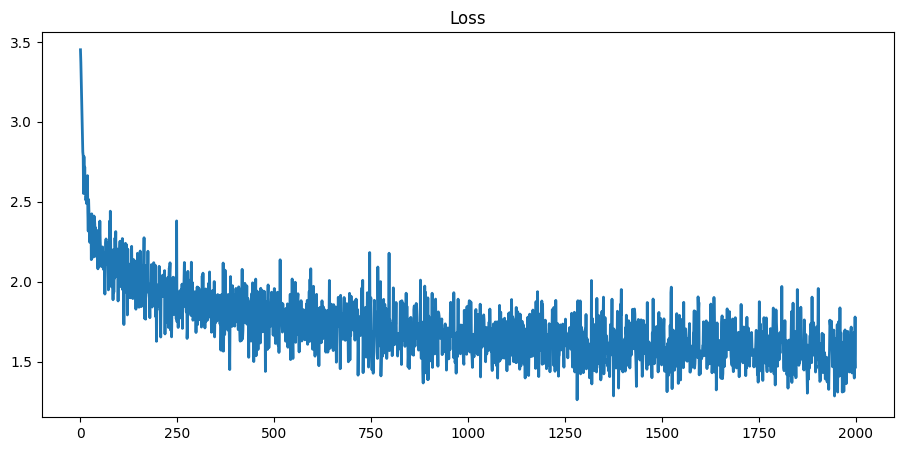

In [32]:
get_plot(losses)

* Yes, final loss become better, and everage (among epoch) loss is better.
* But vanilla rnn, on a couple of epoch had the same good result and learned faster.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [40]:
for i in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("temperature =",i,'\n',generate_sample(model, seed_phrase='<Hello', max_length = 200, temperature=i, vanila = False), '\n')

temperature = 0.1 
 hellow the self thou the self thou the self thy self the be the self thou thou the self thou the be the stare the self thou the self the self thou the self thy self thou the self thou thou the self th 

temperature = 0.2 
 hellow the be the the be the self that the self that thou the be the be the preasure that i show the stare the earth the subjects the be the for the self thou the from the self thou the self thou the  

temperature = 0.5 
 hellow who have a dear the lacking that of thou me that thy love thy song thy be the glatcher the reasent that then be that that light. this thou than eyes be the the seemd in thou show leave that for 

temperature = 1.0 
 hellow with thou are thou are not for fails all the triuld a doth him foth though i appy thy power the in forikeral beby love tomblowsne shay so, but thy learthle it losterow thuse, tolnd, in thine po 

temperature = 2.0 
 hellopnexd,thou, and, gesteed satunims?bbirg tic, that ifle. ethy are nigruch, drven yol

* The lower the temperature, the more common prepositions, pronouns, etc. That is, the words that are most often found in the text.
* At high temperatures, the connection between the characters is lost. The conclusion becomes more random.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [46]:
torch.save(model.state_dict(), "/home/slava/Рабочий стол/made_ml/ml-course/homeworks/lab02_deep_learning/model.pth")


model = LSTM(len(tokens), 100, len(tokens))
model.load_state_dict(torch.load('/home/slava/Рабочий стол/made_ml/ml-course/homeworks/lab02_deep_learning/model.pth'))

<All keys matched successfully>

In [48]:
print(generate_sample(model, seed_phrase='<Hello', max_length = 200, temperature=1, vanila=False))

hellow sick, where that precipines persed for must that in thy mone yet foul greel for bed. lxxvi fair had, compear to that that thy heaver my, but tells of this so fould the that in my breathd thy be


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)